# Value function iteration in the McCall (1970) model

<b>This notebook is based on Sections 22-24 from the <a href="https://python-programming.quantecon.org/">Python Programming for Economics and Finance</a> lecture.</b> <i>The code in this notebook is simplified and abstracts from classes or just-in-time compiling for transparency reasons. The QuantEcon lectures provide further instructions how to accelerate the code, and utilize the Python functionality in much more depth.</i>

We study the problem of a worker who receives wage offers $w$ drawn from a distribution $F(w)$. Denote $V(w)$ the value of an unemployed worker with offer $w$ at hand. Then $V$ satisfies the Bellman equation

$$V\left( w\right) =\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w}{1-\beta} ,c+\beta \int_{0}^{B}V\left( w^{\prime }\right)
dF\left( w^{\prime }\right) \right\} .$$

Implementing the problem on a computer requires several considerations.

<ol>
    <li>We need to evaluate the integral on the right-hand side of the Bellman equation. When the distribution of offers is discrete with finitely many mass points, then the integral can be replaced with a finite sum, otherwise we need to rely on an approximation.</li>
    <li>We need to replace the function $V$ defined on the interval $[0,B]$ with a its approximation defined on a finite grid of nodes. Again, if the distribution of offers is discrete with finitely many mass points, then these mass points can serve as the nodes, since no other offers can be made anyway.</li>
    <li>We need to provide an argument that the method will converge to the correct unique solution. In our case, this is guaranteed by the Banach fixed point theorem, which can be invoked for our problem.</li>
</ol>

## The algorithm

The value function algorithm is given by the following scheme.

<ol>
    <li>Pick an initial guess for the value function, denoted $V_0$.</li>
    <li>Given the $n$-th iteration guess $V_n$, update it as
    \begin{equation}
        V_{n+1}\left( w\right) =\max_{\left\{ \text{accept, reject}\right\} }\left\{
        \frac{w}{1-\beta} ,c+\beta \int_{0}^{B}V_n\left( w^{\prime }\right)
        dF\left( w^{\prime }\right) \right\}.
    \end{equation}
    </li>
    <li>Repeat step 2 until $|V_{n+1}-V_n|$ falls below a given precision threshold.</li>
</ol>

## Association with a finite-horizon problem

Notice the similarity of the value function iteration algorithm with the following finite-horizon problem. Time during which offers arrive is finite, $t=0,1,\ldots,T$. Every period, the worker receives an iid offer drawn from $F(w)$. If the worker accepts, then she stays employed forever (until $t=\infty$) at wage $w$. As long as she stays unemployed, she receives unemployment benefits $c$. If the worker does not accept any offer until the end of period $T$, then time ends, and she receives no further payments. We denote the value function at the beginning of period $t$ (until offer $w_t$ is made) as $\tilde{V}_t(w)$.

<i>This unusual assumption under which employment lasts forever even though otherwise time ends at $T$ is made to exactly mimic the value function iteration algorithm above. We will modify it in other examples.</i>

In this model, the initial guess $V_0(w)=0$ in the value function iteration corresponds to $\tilde{V}_{T+1}(w)$, i.e., the value of staying unemployed at the end of $T$. Subsequently, the iterations reveal that

$$ \tilde{V}_{T+1-n}(w) = V_n(w).$$

The value function iteration algorithm thus effectively implements a solution algorithm for finite horizon problems known as <b>backward induction</b>.

## Implementation

We first need to import libraries required for some specialized tasks. The first line assures that plots are rendered in the current notebook.

In [126]:
%matplotlib inline                       
import numpy as np                       # import library for numerical operations
import scipy.stats as sp                 # import library that includes probability distributions
import matplotlib.pyplot as plt          # import library for drawing
plt.rcParams['figure.figsize'] = (10,6)  # define size of the plots

We now want to write a function that takes as input the parameters of the model, the grid on which we approximate the value function, and the initial guess $V_0$, and produces as output the fixed point $V$, the reservation wage $\bar{w}$, and a couple of iterates $V_0$, $V_1$, $V_2$, $\ldots$.

First define the grid and the wage offer distribution. We use the discrete BetaBinomial distribution with parameters $n$, $a$, $b$ that give substantial flexibility to its shape. You can look up the details on <a href="https://en.wikipedia.org/wiki/Beta-binomial_distribution">Wikipedia</a>. A random variable $X$ with this distribution has realizations from the set $\{0,1,2,\ldots,n\}$ and first two moments

$$E[X;n,a,b] = n\frac{a}{a+b},\qquad Var[X;n,a,b]= n (a+b+n)\frac{ab}{(a+b)^2(a+b+1)}. $$

Since we are interested in draws on the interval $[0,B]$, we rescale and define $w = X *(B/n)$. The wage draws will then be from a discrete grid $0,B/n,2B/n,\ldots,B$. The mean and variance of the random variable $w$ with this distribution are then given by

$$E[w;n,a,b,B] = B\frac{a}{a+b},\qquad Var[w;n,a,b,B]= B^2 \frac{a+b+n}{n}\frac{ab}{(a+b)^2(a+b+1)}. $$

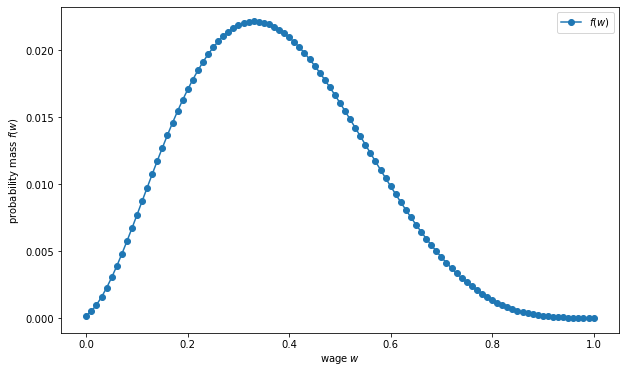

In [191]:
# define the wage offer distribution
B = 1                                         # maximum wage offer
n = 100                                       # number of grid points
w_grid = np.linspace(0,B,n+1)
a, b = 3,5                                   # parameters of the BetaBinomial distribution
f = sp.betabinom(n,a,b)                       # BetaBinomial distribution object
f_grid = f.pmf(np.arange(0,n+1))              # probability mass function
F_grid = f.cdf(np.arange(0,n+1))              # cumulative distribution function

# plot the wage offer distribution
fig, ax = plt.subplots()                                   # define plot
ax.plot(w_grid, f_grid, '-o', label='$f(w)$')              # plot the probability mass function
ax.set(xlabel='wage $w$',ylabel='probability mass $f(w)$') # describe axes
ax.legend()                                                # include legend
plt.show()                                                 # publish graph

Next define the function that solves the Bellman equation.

In [136]:
def mccall_model(w_grid,V0,f,c,β,num_iter=5,err_tol=1e-10,max_iter = 10000):
    # solves the McCall model on a given grid, initial guess V0,
    # discrete density of the wage offer distribution f defined on the grid,
    # unemployment compensation c, and time preference parameter β
    # store first num_iter of the value function iterations, and iterate until precision is reached or
    # max_iter is reached
    
    V_iter = np.zeros(len(w_grid)*num_iter)   # define the matrix that stores first num_iter iterates
    V_iter.shape=(len(w_grid),num_iter)
    V = np.zeros(len(w_grid))                 # define the vector for the value function
    
    V_a = w_grid/(1-β)                        # value of accepting
    V_next = np.empty_like(V_a)               # define an empty vector for the next iterate
    V_cur = V0                                # current iterate
    i = 0
    err = err_tol + 1
    while i < max_iter and err > err_tol:     # iterate until tolerance or maximum iterations are reached
        Q = c+β*sum(V_cur*f)                  # value of rejecting the offer
        V_next = np.maximum(V_a,Q)            # optimal current period decision
    
        if i < num_iter:                      # store first num_iter iterates
            V_iter[:,i]=V_cur

        err = np.max(np.abs(V_next-V_cur))    # compute distance between V_cur and V_next
        V_cur[:] = V_next
        i = i + 1
        
    V[:] = V_next                             # store fixed point
    wbar = (1-β)*Q                            # store reservation wage
    return V,wbar,V_iter

With this function defined, we can call it$\ldots$

In [137]:
# structural parameters of the model
c = 0.4 * B*a/(a+b)                    # unemployment benefits equal 40% of average wage
β = 0.98                               # time preference
# other parameters for computation
err_tol = 1e-10
num_iter = 6
# initial guess
V0 = np.zeros(n+1)

# run value function iteration
V,wbar,V_iter = mccall_model(w_grid=w_grid,V0=V0,f=f_grid,c=c,β=β,num_iter=num_iter,err_tol=err_tol)

$\dots$ and produce a plot of the value function.

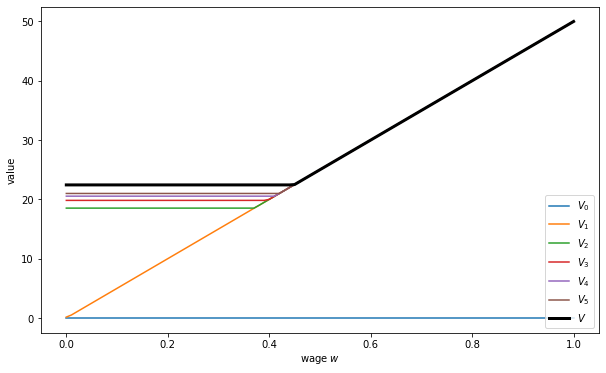

Reservation wage 0.4487727229069701.


In [138]:
fig, ax = plt.subplots()                          # define plot
for i in range(num_iter):                         # plot iterates
    ax.plot(w_grid,V_iter[:,i], label=f'$V_{i}$')

ax.plot(w_grid,V, 'k',label=f'$V$',linewidth=3)   # plot fixed point
ax.set(xlabel='wage $w$',ylabel='value')          # describe axes
ax.legend(loc='lower right')                      # display legend
plt.show()                                        # show plot
print(f'Reservation wage {wbar}.')

## Characterization of the solution

The plot above displays a couple of first iterates $V_n(w)$ and then the value function $V(w)$. We imposed $V_0(w) = 0$, and the sequence of value function iterates $V_n$ is increasing. Consequently, the sequence of the reservation wage iterates is increasing as well.

As an alternative, try adding ${B/(1-\beta)}$ to the initial guess ${V0}$ above, and observe how the sequence of value function iterates evolves now.

## Comparative statics

We can now run the function repeatedly in order to produce comparative statics for the reservation wage. In particular, we are interested in comparative statics in the time-preference parameter and in the mean-preserving spread of the wage offer distribution, modeled as increases in the variance of the wage offer distribution, holding the mean of the wage offer distribution unchanged.

We choose a grid of values for $\beta$. As for the mean-preserving spread, we notice that scaling the wage offer distribution parameters $a,b$ by the same factor $s$ leaves $E[w]$ unchanged but scales the variance. In particular,

$$E[w;n,sa,sb,B] = E[w;n,a,b,B]$$

and

$$Var[w;n,sa,sb,B] = \frac{s(a+b)+n}{a+b+n}\frac{a+b+1}{s(a+b)+1} Var[w;n,a,b,B].$$

Hence we choose a grid for $s$, and then for every value of $s$, we compute the variance of the wage offer distribution. Then, for every pair of $\beta$ and $s$, we resolve the model and record the reservation wage.

In [223]:
β_grid_size = 20
s_grid_size = 30
wbar_grid = np.empty((β_grid_size,s_grid_size))   # array to store recorded wbar values

a, b = 0.3, 0.5
β_vals = np.linspace(0.9,0.99,β_grid_size)        # grid for time preference parameter values
s_vals = np.logspace(0,2,s_grid_size)             # grid for scaling factor values, then recalculate to variances
var_vals = B**2 * (s_vals*(a+b)+n)/n * (a*b)/(a+b)**2/(s_vals*(a+b)+1)

for j,s in enumerate(s_vals):
    f = sp.betabinom(n,s*a,s*b)                   # BetaBinomial distribution object for every new s from the grid
    f_grid = f.pmf(np.arange(0,n+1))              # probability mass function
    for i,β in enumerate(β_vals):
        # resolve the McCall model and record the reservation wage
        V,wbar,V_iter = mccall_model(w_grid=w_grid,V0=V0,f=f_grid,c=c,β=β,num_iter=0,err_tol=err_tol)
        wbar_grid[i,j] = wbar

Finally, plot the calculate values into a fancy contour plot. As expected from the theoretical analysis, the reservation wage increases with the time preference parameter $\beta$, and also increases with the variance of the wage offer distribution.

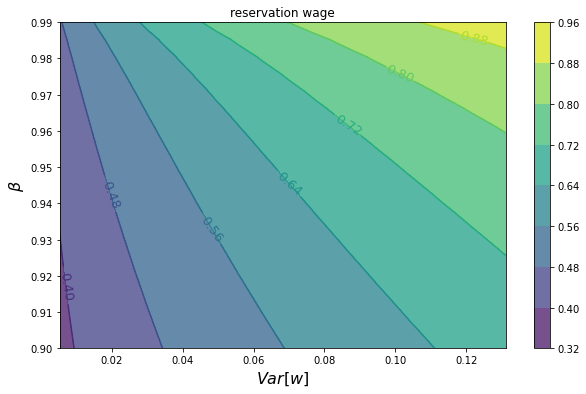

In [227]:
fig, ax = plt.subplots()                                     # define plot

cs1 = ax.contourf(var_vals, β_vals, wbar_grid, alpha=0.75)   # draw color gradient
ctr1 = ax.contour(var_vals, β_vals, wbar_grid)               # draw contours

plt.clabel(ctr1, inline=1, fontsize=13)                      # add values into the contour lines
plt.colorbar(cs1, ax=ax)                                     # add a 'temperature' bar with the color gradient

ax.set_title('reservation wage')                             # add title and describe axes
ax.set_xlabel("$Var[w]$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

plt.show()                                                   # display graph